<a href="https://colab.research.google.com/github/oscarserc/LENGUAJE_NLP/blob/main/Transformers_1_HuggingFace_PrimerosPasos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# -----------------------------------------------------------
# PRACTICAS DE: Natural Language Processing with Transformers
# -----------------------------------------------------------

# GitHub del libro: https://github.com/nlp-with-transformers/notebooks

# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()


Cloning into 'notebooks'...
remote: Enumerating objects: 416, done.
remote: Total 416 (delta 0), reused 0 (delta 0), pack-reused 416
Receiving objects: 100% (416/416), 24.47 MiB | 28.28 MiB/s, done.
Resolving deltas: 100% (190/190), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:

import torch
from transformers import AutoModel
from transformers import AutoTokenizer

DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ckpt = 'distilbert-base-uncased'

tokenizer  = AutoTokenizer.from_pretrained(model_ckpt)
modelo     = AutoModel.from_pretrained(model_ckpt).to(DEVICE)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#**Ahora procedemos a extraer los HIDDEN STATES de la última capa, dada una cadena de prueba**.



In [ ]:

TEXTO_prueba = 'Esto es un texto de prueba'

inputs = tokenizer(TEXTO_prueba, return_tensors='pt')

t = inputs['input_ids'].size()

print(f'-> Input tensor shape: {t} ')
# No sé por qué la siguiente línea da error, parece equivalente:
# print(f' Input tensor shape: {inputs['input_ids'].size()}')

# Resultados tras la tokenización:
# >>>  inputs
# >>>  {'input_ids':      tensor([[  101,  9765,  2080,  9686,  4895,  3793,  2080,  2139, 10975,  5657, 3676,   102]]), 
#       'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
#
# >>> inputs['input_ids'].size()
# >>> torch.Size([1, 12])



-> Input tensor shape: torch.Size([1, 12]) 


In [ ]:

inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
with torch.no_grad():
  salidas = modelo(**inputs)

print(salidas)



BaseModelOutput(last_hidden_state=tensor([[[-0.3024,  0.0159, -0.0572,  ..., -0.1919,  0.2059,  0.3615],
         [-0.2462,  0.0572, -0.1441,  ..., -0.2653,  0.2641,  1.1456],
         [-0.5668, -0.1110, -0.3393,  ..., -0.4900, -0.1839,  0.4386],
         ...,
         [-0.3781, -0.3176, -0.1213,  ..., -0.3429,  0.2468,  0.3225],
         [-0.0483, -0.0363, -0.3424,  ..., -0.1569, -0.0591,  0.3166],
         [ 0.8517,  0.0046, -0.5230,  ...,  0.1543, -0.7547, -0.2428]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
salidas.last_hidden_state.size()

torch.Size([1, 12, 768])

In [ ]:
inputs.items()

dict_items([('input_ids', tensor([[  101,  9765,  2080,  9686,  4895,  3793,  2080,  2139, 10975,  5657,
          3676,   102]], device='cuda:0')), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'))])

#**En tareas de CLASIFICACIÓN se emplea el estado oculto asociado al token [CLS], por lo que probamos a acceder a él**.


In [ ]:
# EL CONTENIDO SERÍA:
# -------------------
# salidas.last_hidden_state[:,0]

# tensor([[-3.0237e-01,  1.5876e-02, -5.7228e-02, -7.0625e-02, -4.3874e-02,
#          -2.5255e-02,  2.1184e-01,  5.4029e-01,  1.0385e-02, -1.7886e-01,
#          -2.8106e-02, -8.8473e-03, -1.4821e-01,  7.7596e-02,  8.2302e-02,
#              ........................................................
#          -6.2101e-03, -1.5798e-01,  1.7134e-01, -1.5268e-01,  7.9127e-02,
#          -1.9194e-01,  2.0594e-01,  3.6150e-01]])   
#
# Coincide con el primero de los vectores que salen en la salida con la
# representación del texto      

# VEMOS QUE EL TAMAÑO ES EL SIGUIENTE:
# ------------------------------------

salidas.last_hidden_state[:,0].size()


torch.Size([1, 768])

# ========================

#**Acudimos de nuevo a la base de datos con etiquetado de EMOCIONES de los TWEETs. Probamos con los lotes de texto**.

In [ ]:

# Cargamos la base de datos de EMOCIÓN
# ------------------------------------

from datasets import load_dataset

bd_emociones = load_dataset('emotion')
bd_emociones


Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

#**Ahora tenemos que TOKENIZAR la base de datos (la parte de entrenamiento)**.

In [ ]:

# Información sobre el tokenizador:
#
#   >>> tokenizer.all_special_tokens
#   >>> ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
#
#   >>> tokenizer.all_special_ids
#   >>> [100, 102, 0, 101, 103]


# Definimos una función apropiada para realizar esta tarea
# --------------------------------------------------------

def tokenizar_datos(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

# PRUEBA CON 2 FILAS
# ------------------
emociones_prueba  = tokenizar_datos(bd_emociones['train'][:2])
emociones_prueba



{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:

# Procedemos a la CODIFICACIÓN
emociones_cod = bd_emociones.map(tokenizar_datos, batched=True, batch_size=None)

# >>> print(emociones_cod['train'].column_names)
# >>> ['attention_mask', 'input_ids', 'label', 'text']

# Lo pasamos a un DATA FRAME de Pandas para realizar una inspección 
emociones_cod.set_format(type='pandas')
emociones_df_tr   = emociones_cod['train'][:]
emociones_df_val  = emociones_cod['validation'][:]
emociones_df_test = emociones_cod['test'][:]

emociones_df_tr.head()


Parameter 'function'=<function tokenizar_datos at 0x7fd8a07c3680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

,attention_mask,input_ids,label,text
0,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...",0,i didnt feel humiliated
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...",0,i can go from feeling so hopeless to so damned...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...",3,im grabbing a minute to post i feel greedy wrong
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...",2,i am ever feeling nostalgic about the fireplac...
4,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...",3,i am feeling grouchy


In [ ]:

emociones_df_val.head()


,attention_mask,input_ids,label,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10047, 3110, 3243, 6517, 1998, 3374, 200...",0,im feeling quite sad and sorry for myself but ...
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2514, 2066, 1045, 2572, 2145, 2559...",0,i feel like i am still looking at a blank canv...
2,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[101, 1045, 2514, 2066, 1037, 11633, 7947, 102...",2,i feel like a faithful servant
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[101, 1045, 2572, 2074, 3110, 27987, 2100, 199...",3,i am just feeling cranky and blue
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2064, 2031, 2005, 1037, 7438, 2030...",1,i can have for a treat or if i am feeling festive


In [ ]:

emociones_df_test.head()


,attention_mask,input_ids,label,text
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[101, 10047, 3110, 2738, 11083, 2061, 10047, 2...",0,im feeling rather rotten so im not very ambiti...
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[101, 10047, 2039, 16616, 2026, 9927, 2138, 10...",0,im updating my blog because i feel shitty
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2196, 2191, 2014, 3584, 2013, 2033...",0,i never make her separate from me because i do...
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2187, 2007, 2026, 26700, 1997, 241...",1,i left with my bouquet of red and yellow tulip...
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[101, 1045, 2001, 3110, 1037, 2210, 15784, 204...",0,i was feeling a little vain when i did this one


#**Ahora probamos con un BATCH**

In [ ]:

# DEFINIMOS LA FUNCIÓN APROPIADA
# ------------------------------

# También operamos sobre la máscara
#
#   >>> tokenizer.model_input_names
#   >>> ['input_ids', 'attention_mask']


def extract_hidden_states(batch):
  # Colocamos los INPUTS en la GPU si existe
  inputs = {k:v.to(DEVICE) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extraemos el estado oculto
  with torch.no_grad():
    last_hidden_state = modelo(**inputs).last_hidden_state

  # Devolvemos el estado oculto asociado al TOKEN [CLS]
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}



In [ ]:

emociones_cod.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


#En CPU esta parte va bastante lenta (40 minutos). 
#En GPU va mucho más rápido (45 segundos).

In [ ]:

emociones_estado_oculto =  emociones_cod.map(extract_hidden_states, batched=True)


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:

# Parece que al llamar a MAP desde la estructura de datos EMOCIONES_COD,
# automáticamente se anexa lo devuelto por el procedimiento.
# Vemos que aparece una nueva columna:
#              hidden_state
emociones_estado_oculto


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'hidden_state', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

#**Con toda esta parte de PREPROCESAMIENTO estamos en condiciones de entrenar un CLASIFICADOR.** 
#· Los 'estados ocultos' nos servirán de **FEATURES**. 
#· Las 'etiquetas' sirven de **TARGETS**.

In [ ]:

import numpy as np

# PREPARAMOS LAS DISTINTAS ESTRUCTURAS DE DATOS
# Variables explicativas:
X_train = np.array(emociones_estado_oculto['train']['hidden_state'])
X_valid = np.array(emociones_estado_oculto['validation']['hidden_state'])

# Variable respuesta:
y_train = np.array(emociones_estado_oculto['train']['label'])
y_valid = np.array(emociones_estado_oculto['validation']['label'])

# DIMENSIONES:
X_train.shape, X_valid.shape



((16000, 768), (2000, 768))

#Visualizamos los 'estados ocultos' proyectando desde las 768 dimensiones a un espacio bidimensional. Empleamos el algoritmo UMAP.

In [ ]:

from umap import UMAP
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Escalado de las features a un rango [0,1]
X_escalado = MinMaxScaler().fit_transform(X_train)

# Instanciación del objeto con el que ejecutar el algoritmo
mapper    = UMAP(n_components=2, metric='cosine').fit(X_escalado)



/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:

# Creamos un DATAFRAME con las proyecciones en 2D
df_embedding = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_embedding['label'] = y_train
df_embedding.head()


,X,Y,label
0,4.194444,5.948105,0
1,-3.165143,5.684402,0
2,5.153987,2.423068,3
3,-2.573132,3.316314,2
4,-3.628083,3.840767,3


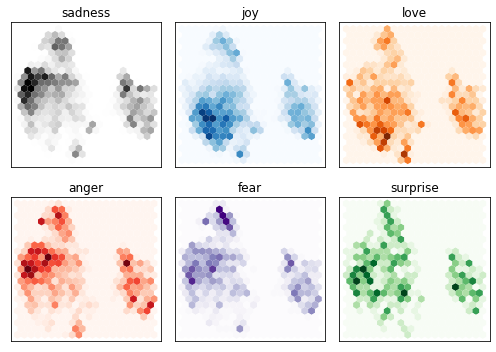

In [ ]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes      = axes.flatten()

cmaps  = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = bd_emociones['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_embedding_sub = df_embedding.query(f'label == {i}')
  axes[i].hexbin(df_embedding_sub['X'], df_embedding_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()  


#**Entrenamiento del CLASIFICADOR**.

In [ ]:

# Tiempo de entrenamiento: unos 5 minutos

from sklearn.linear_model import LogisticRegression

clasif_lr = LogisticRegression(max_iter=3000)
clasif_lr.fit(X_train, y_train)



LogisticRegression(max_iter=3000)

#Score obtenido ('accuracy').

In [ ]:
clasif_lr.score(X_valid, y_valid)

0.6335

#Comparamos con un clasificador 'Dummy' que proporcione una 'baseline'. En este caso asigna ciegamente las predicciones a la clase más representada.

In [ ]:

from sklearn.dummy import DummyClassifier

clasif_dummy = DummyClassifier(strategy='most_frequent')
clasif_dummy.fit(X_train, y_train)
clasif_dummy.score(X_valid, y_valid)



0.352

#Analizamos la matrix de confusión.

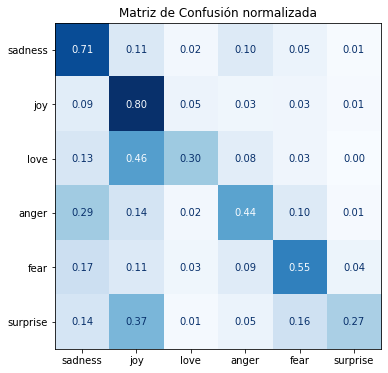

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Matriz de Confusión normalizada')
  plt.xlabel('')  # Predicted label
  plt.ylabel('')  # True label
  plt.show()

y_preds = clasif_lr.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


# ======================

#**Ahora acoplamos un CLASIFICADOR como cabeza del TRANSFORMER**. 
#**Emplearemos un TRANSFORMER PREENTRENADO (DistilBERT)**.
#Anteriormente nos limitamos a extraer el estado oculto de un transformer preentrenado y lo pasamos como variables junto a las etiquetas, para que un clasificador (Regresión Logística) fuera entrenado para discriminar entre los grupos.

In [ ]:

from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(DEVICE))



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

#Medidas del desempeño del modelo.

In [ ]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds  = pred.predictions.argmax(-1)
  f1  = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)

  return {'accuracy': acc, 'f1': f1}


#Preparamos el entrenamiento del TRANSFORMER.

In [ ]:

# TIEMPO DE ENTRENAMIENTO: 3 min
# ------------------------------

# PARA SUBIR AL HUB ('Hugging Face')
# ----------------------------------
#  from hugginface_hub import notebook_login
#  notebook_login()


from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emociones_cod['train']) // batch_size
model_name    = f'{model_ckpt}-finetuned-emotion'

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #push_to_hub=True,  # PUESTO A 'True' SE HA DE ACCEDER VÍA LOGGING A HuggingFace
                                  log_level='error')

# PONER: model = model (ya que es el que hemos puesto justo arriba: AutoModelForSequenceClassification)
# El que llamé 'modelo' no tiene cabeza para clasificar, por lo que sale un error
#
#       forward() got an unexpected keyword argument 'labels'
#
# En la documentación aclara este punto de porqué salta este tipo de errores cuando se pasa el modelo al TRAINER.
#
#      is not something you can use directly with Trainer as it doesn't have any objective 
#      (it's the base model without head). You should pick a model with head relevant to your task.

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emociones_cod['train'],
                  eval_dataset=emociones_cod['validation'],
                  tokenizer=tokenizer)

# ERROR: No todos los tensores en el mismo dispositivo
# ----------------------------------------------------
#
# Pruebo solución de:
# https://github.com/nlp-with-transformers/notebooks/issues/31
#
#   On Kaggle I get dict, and on the GPU machine I'm getting 
#      transformers.tokenization_utils_base.BatchEncoding.
#
#   The error is due to this type difference; when the trainer prepares the 
#   input checks if the data is an instance of dict, but BatchEncoding isn't 
#   (it's an instance of UserDict).
#
# New code - wrap collator in a dictionary          (Prueba 1)  FUNCIONA
# ----------------------------------------
old_collator = trainer.data_collator
trainer.data_collator = lambda data: dict(old_collator(data))
# ------------
# End new code

trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.846300,0.315502,0.909000,0.905422
2,0.253500,0.213906,0.929000,0.928986


TrainOutput(global_step=500, training_loss=0.5499342956542969, metrics={'train_runtime': 222.0008, 'train_samples_per_second': 144.144, 'train_steps_per_second': 2.252, 'total_flos': 720342861696000.0, 'train_loss': 0.5499342956542969, 'epoch': 2.0})

In [ ]:

salida_predicciones = trainer.predict(emociones_cod['validation'])
salida_predicciones.metrics


{'test_accuracy': 0.929,
 'test_f1': 0.9289855155924005,
 'test_loss': 0.21390603482723236,
 'test_runtime': 4.2713,
 'test_samples_per_second': 468.245,
 'test_steps_per_second': 7.492}

In [ ]:

# TIPO DE OBJETO
# --------------
# El objeto 'salida_predicciones', es del tipo transformers.trainer_utils.PredictionOutput
#
#  >>> type(salida_predicciones)
#  >>> transformers.trainer_utils.PredictionOutput

# ESTRUCTURA
# ----------
#    predictions       array
#    labels_ids        array
#    metrics           parece un diccionario
#        {'test_loss': ...., 'test_accuracy': ...., 'test_f1': ...., 'test_runtime': ...., 'test_samples_por_second': ...., 'test_steps_per_second: ....} 

salida_predicciones


PredictionOutput(predictions=array([[ 4.4974866 , -0.983806  , -0.37214717, -0.7113896 , -0.7817416 ,
        -1.1056234 ],
       [ 4.607607  , -0.9941625 , -0.95141405, -0.4877539 , -0.17989694,
        -1.0875555 ],
       [-1.0997597 ,  2.1270144 ,  2.7763214 , -1.1561971 , -1.4471296 ,
        -1.738113  ],
       ...,
       [-1.4068179 ,  4.5254226 , -0.042552  , -1.2959367 , -1.4676558 ,
        -1.1991997 ],
       [-1.5152825 ,  2.6923616 ,  2.6114573 , -1.4378455 , -1.5304339 ,
        -1.4937874 ],
       [-1.6288033 ,  4.208003  ,  0.15083152, -1.6321303 , -1.6074208 ,
        -0.48375106]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.21390603482723236, 'test_accuracy': 0.929, 'test_f1': 0.9289855155924005, 'test_runtime': 4.2713, 'test_samples_per_second': 468.245, 'test_steps_per_second': 7.492})

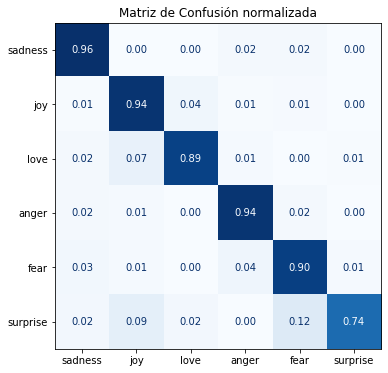

In [ ]:

# Sacamos las predicciones
y_preds = np.argmax(salida_predicciones.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)



#Análisis de los ERRORES

In [ ]:

# Procedemos a ORDENAR las MUESTRAS DE VALIDACIÓN en función de la 'Loss' del modelo.
# (El siguiente procedimiento se encarga de que en la 'pasada forward' se pase la etiqueta
# y la 'loss' es automáticamente calculada y devuelta).
# Se devuelve la 'Loss' y la etiqueta predicha

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Colocamos todos los TENSORES INPUT en el mismo DEVICE que el MODELO
  inputs = {k:v.to(DEVICE) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    # CUIDADO 'modelo' era sin la cabeza
    salida     = model(**inputs)
    pred_label = torch.argmax(salida.logits, axis=-1)
    loss       = cross_entropy(salida.logits, batch['label'].to(DEVICE), reduction='none')

  # Recolocamos la salida en la CPU, para poder integrarlo con las otras columnas del DATASET
  return { 'loss'           : loss.cpu().numpy(),
           'predicted_label': pred_label.cpu().numpy()}  




In [ ]:

# Para obtener la 'loss' de todas las muestras, acudimos a: map()

# Antes convertimos en TENSORES de PyTorch el conjunto del DATASET
emociones_cod.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# CÁLCULO DE LOS VALORES DE LA 'Loss'
emociones_cod['validation'] = emociones_cod['validation'].map(forward_pass_with_label, batched=True, batch_size=16)



  0%|          | 0/125 [00:00<?, ?ba/s]

#Ahora creamos un DATAFRAME para guardar todos los resultados anteriores

In [ ]:

# FUNCIÓN AUXILIAR
# ----------------
def label_int2str(row):
  return bd_emociones['train'].features['label'].int2str(row)
# --------------------------------------------------------


emociones_cod.set_format('pandas')

columnas = ['text','label','predicted_label','loss']
df_test                    = emociones_cod['validation'][:][columnas]
df_test['label']           = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)



In [ ]:

df_test.sort_values('loss', ascending=False).head(10)


,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.638925
1950,i as representative of everything thats wrong ...,surprise,sadness,5.342159
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.268867
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.060406
882,i feel badly about reneging on my commitment t...,love,sadness,4.813507
1509,i guess this is a memoir so it feels like that...,joy,fear,4.796506
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.683459
1274,i am going to several holiday parties and i ca...,joy,sadness,4.603086
1111,im lazy my characters fall into categories of ...,joy,fear,4.450861
1662,i did not directly react to the spot fixing co...,joy,anger,4.441637


In [ ]:

df_test.sort_values('loss', ascending=True).head(10)


,text,label,predicted_label,loss
19,i had lunch with an old friend and it was nice...,joy,joy,0.017302
424,i believe everyone can feel energetic after li...,joy,joy,0.017543
1873,i feel practically virtuous this month i have ...,joy,joy,0.017749
1636,i feel so lucky that my mom is alive and i get...,joy,joy,0.017759
578,i got to christmas feeling positive about the ...,joy,joy,0.017776
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.017820
1254,im fighting some sniffles that developed last ...,joy,joy,0.017830
1263,i feel this way about blake lively,joy,joy,0.017904
1320,im feeling positive but its impossible to desc...,joy,joy,0.017934
763,i feel peaceful with them being where they are...,joy,joy,0.017952
